# Resources

 This notebook uses the surv_nn environment
 
 Resources:
 
 Youtube Videos:
  - https://www.youtube.com/watch?v=G5Q-JuVzFE0
  - https://www.youtube.com/watch?v=-vmV4qA0ztQ
  - https://www.youtube.com/watch?v=VxjfI7vkjhU
 
Papers:
 - SurvNet: https://www.frontiersin.org/articles/10.3389/fonc.2020.588990/full#f2
 - DeepSurv: https://bmcmedresmethodol.biomedcentral.com/track/pdf/10.1186/s12874-018-0482-1.pdf
 - Cox-PASNet: https://bmcmedgenomics.biomedcentral.com/articles/10.1186/s12920-019-0624-2
 
Software:
 - https://github.com/havakv/pycox
 - https://github.com/jaredleekatzman/DeepSurv
 - https://pytorch.org/tutorials/
 - https://github.com/DataX-JieHao/Cox-PASNet

# PyCox
Recreating this introduction to pycox
 - https://nbviewer.org/github/havakv/pycox/blob/master/examples/01_introduction.ipynb


In [1]:
import torch
import numpy as np
import torchtuples as tt 
import matplotlib.pyplot as plt

from lifelines import CoxPHFitter

from sklearn.preprocessing import StandardScaler

from pycox.datasets import metabric
from pycox.models import LogisticHazard
from pycox.evaluation import EvalSurv

In [3]:
np.random.seed(1234)
_ = torch.manual_seed(123)

In [4]:
df_train = metabric.read_df()
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

In [5]:
cols_standardize = ['x0', 'x1', 'x2', 'x3', 'x8']
cols_leave = ['x4', 'x5', 'x6', 'x7']

In [6]:
standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

In [7]:
for row, scaler in standardize:
    df_train[row] = scaler.fit_transform(df_train[row])
    df_test[row] = scaler.transform(df_test[row])
    df_val[row] = scaler.transform(df_val[row])


In [8]:
x_train = df_train[cols_standardize + cols_leave].astype('float32').to_numpy()
x_test = df_test[cols_standardize + cols_leave].astype('float32').to_numpy()
x_val = df_val[cols_standardize + cols_leave].astype('float32').to_numpy()

## Label Transforms

In [9]:
num_durations = 10

labtrans = LogisticHazard.label_transform(num_durations)
# labtrans = PMF.label_transform(num_durations)
# labtrans = DeepHitSingle.label_transform(num_durations)

get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)

## Model

In [10]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1

net = torch.nn.Sequential(
    torch.nn.Linear(in_features, 32),
     torch.nn.ReLU(),
     torch.nn.BatchNorm1d(32),
     torch.nn.Dropout(0.1),
    
     torch.nn.Linear(32, 32),
     torch.nn.ReLU(),
     torch.nn.BatchNorm1d(32),
     torch.nn.Dropout(0.1),
   
     torch.nn.Linear(32, out_features)
)

In [11]:
net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

In [12]:
model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)


In [13]:
batch_size = 256 #256
epochs = 100
callbacks = [tt.cb.EarlyStopping()]

In [14]:
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val) # , callbacks, val_data=val)

0:	[0s / 0s],		train_loss: 3.0792,	val_loss: 2.9861
1:	[0s / 0s],		train_loss: 2.7489,	val_loss: 2.6268
2:	[0s / 0s],		train_loss: 2.4555,	val_loss: 2.2492
3:	[0s / 0s],		train_loss: 2.1038,	val_loss: 1.8631
4:	[0s / 0s],		train_loss: 1.7819,	val_loss: 1.5735
5:	[0s / 0s],		train_loss: 1.5585,	val_loss: 1.4190
6:	[0s / 0s],		train_loss: 1.4709,	val_loss: 1.3751
7:	[0s / 0s],		train_loss: 1.4167,	val_loss: 1.3655
8:	[0s / 0s],		train_loss: 1.4129,	val_loss: 1.3597
9:	[0s / 0s],		train_loss: 1.3746,	val_loss: 1.3548
10:	[0s / 0s],		train_loss: 1.3603,	val_loss: 1.3562
11:	[0s / 0s],		train_loss: 1.3416,	val_loss: 1.3552
12:	[0s / 0s],		train_loss: 1.3472,	val_loss: 1.3509
13:	[0s / 0s],		train_loss: 1.3369,	val_loss: 1.3479
14:	[0s / 0s],		train_loss: 1.3289,	val_loss: 1.3491
15:	[0s / 0s],		train_loss: 1.3208,	val_loss: 1.3516
16:	[0s / 0s],		train_loss: 1.3223,	val_loss: 1.3624
17:	[0s / 0s],		train_loss: 1.3227,	val_loss: 1.3621
18:	[0s / 0s],		train_loss: 1.2927,	val_loss: 1.3634
19:

<AxesSubplot:>

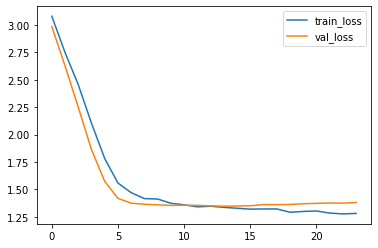

In [16]:
log.plot()

In [17]:
val

(array([[-0.38457575, -0.89326   , -0.74212027, ...,  0.        ,
          0.        ,  1.        ],
        [-0.3665086 , -0.3167301 ,  0.05380753, ...,  1.        ,
          0.        ,  1.        ],
        [-0.5659799 , -0.83177716, -0.9836813 , ...,  1.        ,
          1.        ,  1.        ],
        ...,
        [-0.5302728 ,  0.5557188 ,  0.24615282, ...,  0.        ,
          0.        ,  1.        ],
        [-0.8310751 ,  0.80899894,  0.56936073, ...,  0.        ,
          0.        ,  1.        ],
        [-0.7328408 ,  0.42610374, -0.10061071, ...,  0.        ,
          0.        ,  1.        ]], dtype=float32),
 (array([3, 2, 4, 2, 5, 3, 1, 3, 4, 1, 5, 1, 5, 3, 2, 1, 5, 3, 4, 0, 2, 5,
         7, 5, 4, 3, 2, 4, 5, 6, 1, 1, 3, 7, 1, 1, 4, 2, 4, 6, 6, 1, 3, 6,
         2, 2, 4, 1, 2, 3, 4, 2, 2, 5, 4, 1, 1, 3, 6, 1, 5, 2, 3, 6, 2, 5,
         3, 2, 5, 4, 4, 4, 2, 1, 3, 2, 5, 2, 8, 4, 1, 2, 2, 2, 3, 2, 4, 1,
         3, 3, 1, 2, 3, 1, 5, 2, 6, 2, 3, 3, 5, 2, 6, 2, 4

In [18]:
x_train.shape

(1218, 9)

# Prediction

In [19]:
surv = model.predict_surv_df(x_test)

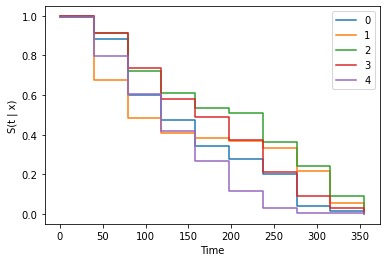

In [20]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [21]:
surv = model.interpolate(10).predict_surv_df(x_test)

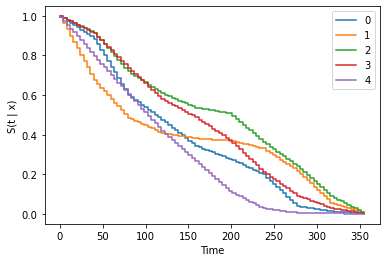

In [22]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [94]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [95]:
ev.concordance_td('antolini')

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


0.664589427275425

# Comparison to CPH

In [108]:
cph = CoxPHFitter().fit(df_train, 'duration', 'event')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 1218 total observations, 482 right-censored observations>
             duration col = 'duration'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 1218
number of events observed = 736
   partial log-likelihood = -4576.34
         time fit was run = 2022-05-22 18:52:43 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
x0          0.04       1.04       0.04            -0.05             0.13                 0.96                 1.14
x1         -0.09       0.92       0.04            -0.17            -0.00                 0.84                 1.00
x2          0.10       1.11       0.04             0.03             0.18                 1.03                 1.20
x3          0.12       1.13       0.04             0.05             0.20                 1.05                 1.22
x4          0.10       1.10       0.08            -0.06             0.26                 0.94                 1.30
x5         -0.18       0.84       0.08            -0.33            -0.02                 0.72                 0.98
x6          0.93       2.54       0.12             0.69             1.17                 2.00                 3.23
x7          0.10       1.11       0.13            -0.14             0.35                 0.87                 1.42
x8          0.60       1.81       0.05             0.50             0.69                 1.65                 2.00

            cmp to     z      p   -log2(p)
covariate                                 
x0            0.00  0.93   0.35       1.50
x1            0.00 -1.99   0.05       4.43
x2            0.00  2.66   0.01       7.00
x3            0.00  3.17 <0.005       9.37
x4            0.00  1.19   0.23       2.09
x5            0.00 -2.26   0.02       5.40
x6            0.00  7.65 <0.005      45.50
x7            0.00  0.83   0.40       1.30
x8            0.00 12.15 <0.005     110.46
---
Concordance = 0.64
Partial AIC = 9170.69
log-likelihood ratio test = 212.43 on 9 df
-log2(p) of ll-ratio test = 133.17

In [111]:
cph.score(df_test, scoring_method = "concordance_index")

0.6503455000211963

# Rossi Model Bakeoff

In [2]:
import seaborn as sns

from lifelines.datasets import load_rossi
from sklearn.model_selection import train_test_split

In [3]:
df = load_rossi()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 432 entries, 0 to 431
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   week    432 non-null    int64
 1   arrest  432 non-null    int64
 2   fin     432 non-null    int64
 3   age     432 non-null    int64
 4   race    432 non-null    int64
 5   wexp    432 non-null    int64
 6   mar     432 non-null    int64
 7   paro    432 non-null    int64
 8   prio    432 non-null    int64
dtypes: int64(9)
memory usage: 30.5 KB


In [5]:
df.describe()

,week,arrest,fin,age,race,wexp,mar,paro,prio
count,432.000000,432.000000,432.00000,432.000000,432.000000,432.000000,432.000000,432.000000,432.000000
mean,45.854167,0.263889,0.50000,24.597222,0.877315,0.571759,0.122685,0.618056,2.983796
std,12.662293,0.441251,0.50058,6.113375,0.328456,0.495398,0.328456,0.486426,2.896068
min,1.000000,0.000000,0.00000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50.000000,0.000000,0.00000,20.000000,1.000000,0.000000,0.000000,0.000000,1.000000
50%,52.000000,0.000000,0.50000,23.000000,1.000000,1.000000,0.000000,1.000000,2.000000
75%,52.000000,1.000000,1.00000,27.000000,1.000000,1.000000,0.000000,1.000000,4.000000
max,52.000000,1.000000,1.00000,44.000000,1.000000,1.000000,1.000000,1.000000,18.000000


In [6]:
train, test = train_test_split(df, test_size=0.3, random_state=42)

In [7]:
cph = CoxPHFitter().fit(train, 'week', 'arrest')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 302 total observations, 226 right-censored observations>
             duration col = 'week'
                event col = 'arrest'
      baseline estimation = breslow
   number of observations = 302
number of events observed = 76
   partial log-likelihood = -410.52
         time fit was run = 2022-05-22 22:37:19 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
fin        -0.61       0.54       0.24            -1.08            -0.14                 0.34                 0.87
age        -0.05       0.95       0.03            -0.10             0.00                 0.90                 1.00
race        0.27       1.32       0.36            -0.43             0.98                 0.65                 2.67
wexp        0.08       1.08       0.25            -0.42             0.58                 0.66                 1.78
mar        -0.68       0.51       0.48            -1.62             0.27                 0.20                 1.30
paro       -0.13       0.88       0.24            -0.59             0.34                 0.55                 1.40
prio        0.11       1.12       0.03             0.04             0.18                 1.04                 1.20

            cmp to     z      p   -log2(p)
covariate                                 
fin           0.00 -2.54   0.01       6.50
age           0.00 -1.91   0.06       4.17
race          0.00  0.76   0.45       1.16
wexp          0.00  0.31   0.76       0.40
mar           0.00 -1.41   0.16       2.65
paro          0.00 -0.53   0.59       0.75
prio          0.00  3.20 <0.005       9.52
---
Concordance = 0.66
Partial AIC = 835.05
log-likelihood ratio test = 26.26 on 7 df
-log2(p) of ll-ratio test = 11.11

In [8]:
cph.score(test, scoring_method = "concordance_index")

0.5714626580768313

In [9]:
cols_standardize = ['age', 'prio']
cols_other = ['fin', 'race', 'wexp', 'mar', 'paro']
standardize = [([col], StandardScaler()) for col in cols_standardize]
for row, scaler in standardize:
    train[row] = scaler.fit_transform(train[row])
    test[row] = scaler.transform(test[row])

In [10]:
xtrain = train[cols_standardize + cols_other].astype('float32').to_numpy()
xtest = test[cols_standardize + cols_other].astype('float32').to_numpy()

In [66]:
num_durations = 2

labtrans = LogisticHazard.label_transform(num_durations)

get_target = lambda df: (df['week'].values, df['arrest'].values)

ytrain = labtrans.fit_transform(*get_target(train))
ytest = labtrans.transform(*get_target(test))

train_post = (xtrain, ytrain)
test_post = (xtest, ytest)

In [132]:
in_features = xtrain.shape[1]
lin_nodes = 8
num_nodes = [lin_nodes, lin_nodes]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1

net = torch.nn.Sequential(
    torch.nn.Linear(in_features, lin_nodes),
     torch.nn.ReLU(),
     torch.nn.BatchNorm1d(lin_nodes),
     torch.nn.Dropout(0.1),
    
     torch.nn.Linear(lin_nodes, lin_nodes),
     torch.nn.ReLU(),
     torch.nn.BatchNorm1d(lin_nodes),
     torch.nn.Dropout(0.1),
   
     torch.nn.Linear(lin_nodes, out_features)
)

In [140]:
net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

In [141]:
model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)


In [142]:
batch_size = 16 #256
epochs = 100
callbacks = [tt.cb.EarlyStopping(patience = 3)]

In [143]:
log = model.fit(xtrain, ytrain, batch_size, epochs, callbacks, val_data = test_post) # , callbacks, val_data=val)

0:	[0s / 0s],		train_loss: 1.2927,	val_loss: 1.1534
1:	[0s / 0s],		train_loss: 1.0400,	val_loss: 0.9186
2:	[0s / 0s],		train_loss: 0.7757,	val_loss: 0.6967
3:	[0s / 0s],		train_loss: 0.6398,	val_loss: 0.6460
4:	[0s / 0s],		train_loss: 0.5909,	val_loss: 0.6279
5:	[0s / 0s],		train_loss: 0.5590,	val_loss: 0.6062
6:	[0s / 0s],		train_loss: 0.5402,	val_loss: 0.6097
7:	[0s / 0s],		train_loss: 0.5381,	val_loss: 0.6027
8:	[0s / 0s],		train_loss: 0.5232,	val_loss: 0.5914
9:	[0s / 0s],		train_loss: 0.5382,	val_loss: 0.5947
10:	[0s / 0s],		train_loss: 0.5300,	val_loss: 0.5886
11:	[0s / 0s],		train_loss: 0.5267,	val_loss: 0.6042
12:	[0s / 0s],		train_loss: 0.5174,	val_loss: 0.5931
13:	[0s / 0s],		train_loss: 0.5249,	val_loss: 0.5855
14:	[0s / 0s],		train_loss: 0.4992,	val_loss: 0.6099
15:	[0s / 0s],		train_loss: 0.5317,	val_loss: 0.6048
16:	[0s / 0s],		train_loss: 0.5142,	val_loss: 0.5958


<AxesSubplot:>

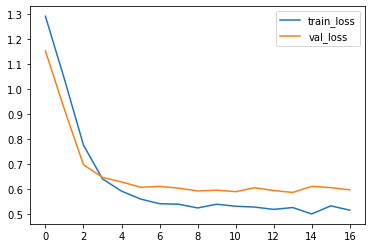

In [144]:
log.plot()

In [145]:
durations_test, events_test = get_target(test)

In [146]:
surv = model.interpolate(10).predict_surv_df(xtest)
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
ev.concordance_td('antolini')

0.6170365068002863

In [147]:
tt.cb.EarlyStopping?